# Drone Model-Predictive Control

## Package Imports

In [1]:
#pip install underactuated --extra-index-url https://drake-packages.csail.mit.edu/whl/nightly/

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

from pydrake.all import (
    AbstractValue, AddMultibodyPlantSceneGraph,ConstantVectorSource, BasicVector,BallRpyJoint,
    DiagramBuilder,DirectCollocation, DirectTranscription, MathematicalProgram, QuadraticCost,
    BoundingBoxConstraint, LinearConstraint,Cost, Constraint,LinearEqualityConstraint,FirstOrderTaylorApproximation,
    FiniteHorizonLinearQuadraticRegulatorOptions, FindResourceOrThrow, LinearSystem, Linearize, 
    LeafSystem_,ExternallyAppliedSpatialForce_, LeafSystem,ExternallyAppliedSpatialForce, 
    LogVectorOutput, MultibodyPlant, MakeFiniteHorizonLinearQuadraticRegulator, MultibodyPlant,
    MathematicalProgram, MeshcatVisualizerParams, MeshcatVisualizer, Parser, PortDataType,
    plot_system_graphviz, Propeller, PropellerInfo, PiecewisePolynomial, RandomSource, 
    RandomDistribution, PrismaticJoint, RigidBody, RigidTransform, Role, RotationMatrix, 
    SceneGraph, Simulator, Solve, StartMeshcat, SpatialInertia, SolverOptions, CommonSolverOption,
    TrajectorySource, Trajectory,  UnitInertia, VectorSystem, TemplateSystem, UnitInertia, eq, Rgba)

from pydrake.examples import (QuadrotorGeometry, QuadrotorPlant, StabilizingLQRController)
#import underactuated.meshcat_cpp_utils
from underactuated.meshcat_utils import MeshcatSliders

from pydrake.multibody.plant import Wing

from timeit import default_timer as timer




## Start Meshcat Visualizer

In [3]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()
# define starting figure number
fig_num = 0;

INFO:drake:Meshcat listening for connections at https://385c23f0-60d3-43e9-8424-58e951645a69.deepnoteproject.com/7001/


## Define the Obstacle class 

In [4]:
class Obstacle():

    def __init__(self, sdf, p, body_name, height, width, depth):

        self.sdf = sdf
        self.position = p
        self.body_name = body_name
        self.height = height
        self.width = width
        self.depth = depth


    #parse sdf file to instantiate object and weld it to the simulation world
    def connect_obstacle_to_world(self, obstacle_plant, scene_graph):

        parser = Parser(obstacle_plant, scene_graph)

        self.model_instance = parser.AddModelFromFile(self.sdf)
        self.body = obstacle_plant.GetBodyByName(self.body_name, self.model_instance)
        obstacle_plant.WeldFrames(obstacle_plant.world_frame(), self.body.body_frame(), RigidTransform(p=self.position))

    # calculate 3D distance vector from quadrotor to object
    # quad_state parameter is truncated version of full state [x,y,z]
    def distance_from_object(self, quad_state):
        return quad_state - self.position

    def detect_collision(self, quad_context):
        quad_state = quad_context.get_continuous_state().get_vector().CopyToVector()
        # print(quad_state)
        dist = self.distance_from_object(quad_state[:3])

        if (np.linalg.norm(dist)  <= 0.75 ):
            return True
        else:
            return False



## Define Offline Trajectory Optimization Class

Find an optimal trajectory from an initial condition to a target destination, that minimizes time to target destination, and adheres to thrust limits

In [5]:
class QuadrotorTrajOpt():

    def __init__(self, init_state, target_state, num_time_samples, thrust_limit):
        self.init_state = init_state
        self.target_state = target_state
        self.num_time_samples = num_time_samples
        self.thrust_limit = thrust_limit


    def dir_col_opt(self, quadrotor_plant, quadrotor_context, obstacle_list):

        # use direct collocation to integrate quadrotor dynamics
        # DirectCollation classe performs Direct transcription trajectory optimization using nonlinear programming and collocation
        # It assumes a first-order hold on the input trajectory and a cubic spline representation of the state trajectory, and adds dynamic constraints 
        # (and running costs) to the midpoints as well as the breakpoints in order to achieve a 3rd order integration accuracy.
        dircol = DirectCollocation(quadrotor_plant,
                                quadrotor_context,
                                num_time_samples=self.num_time_samples,
                                minimum_timestep=0.05,
                                maximum_timestep=0.2)

        #Returns a reference to the MathematicalProgram associated with the trajectory optimization problem.
        prog = dircol.prog()

        # add constraint that enforces that all timesteps have equal duration (ensures more efficient optimization)
        dircol.AddEqualTimeIntervalsConstraints()

        # Returns placeholder decision variables (not actually declared as decision variables in the MathematicalProgram) 
        # associated with the input, u, but with the time-index undetermined.
        u = dircol.input()

        x = dircol.state()

        # print(f"state = {x}")
        # print(f"input = {u}")

        #TODO: constrain roll, pitch & yaw to be below 90

        # enforce collision avoidance constraints for each obstacle

        for obs in obstacle_list:
            # pass [x,y,z] position of quadrotor to get distance vector 
            quad_state_xyz = x[:3]
            distance_vector = obs.distance_from_object(quad_state_xyz)
            #x distance from center of object
            dircol.AddConstraintToAllKnotPoints(np.linalg.norm(distance_vector) >= 1.0 )
        
        #enforce constraint that drone cannot fly underground
        dircol.AddConstraintToAllKnotPoints(x[2]>= 0.0)

        #enforce constraint drone cannot fly above tree line
        dircol.AddConstraintToAllKnotPoints(x[2]<= 1.3)

        # # enforce individual thrust limits for each propellor
        dircol.AddConstraintToAllKnotPoints(u[0] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[0])

        dircol.AddConstraintToAllKnotPoints(u[1] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[1])

        dircol.AddConstraintToAllKnotPoints(u[2] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[2])

        dircol.AddConstraintToAllKnotPoints(u[3] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[3])

        # add initial state constraint (first parameter is upper bound, second parameter is lower bound, 3rd parameter is variable being constrained)
        dircol.AddBoundingBoxConstraint(self.init_state, self.init_state,
                                    dircol.initial_state())

        # add final state constraint
        dircol.AddBoundingBoxConstraint(self.target_state, self.target_state,
                                    dircol.final_state())

        R = 1  # Cost on input "effort".
        dircol.AddRunningCost(R * u[0]**2)
        dircol.AddRunningCost(R * u[1]**2)
        dircol.AddRunningCost(R * u[2]**2)
        dircol.AddRunningCost(R * u[3]**2)


        # # add contraints on angle 
        # angle_limit = 85
        # dircol.AddConstraintToAllKnotPoints(x[3] <= angle_limit)
        # dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[3])
        # dircol.AddConstraintToAllKnotPoints(x[4] <= angle_limit)
        # dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[4])
        # dircol.AddConstraintToAllKnotPoints(x[5] <= angle_limit)
        # dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[5])
        # dircol.AddConstraintToAllKnotPoints(x[6] <= angle_limit)
        # dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[6])
        # dircol.AddConstraintToAllKnotPoints(x[7] <= angle_limit)
        # dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[7])
        # dircol.AddConstraintToAllKnotPoints(x[8] <= angle_limit)
        # dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[8])
        # dircol.AddConstraintToAllKnotPoints(x[9] <= angle_limit)
        # dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[9])
        # dircol.AddConstraintToAllKnotPoints(x[10] <= angle_limit)
        # dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[10])
        # dircol.AddConstraintToAllKnotPoints(x[11] <= angle_limit)
        # dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[11])


        # Add a final cost equal to the total duration.
        dircol.AddFinalCost(dircol.time())

        # Construct an initial guess at an optimal trajectory
        # PiecewisePolynomial.FirstOrderHold Constructs a piecewise linear PiecewisePolynomial using matrix samples.
        breaks = [0., 4.]
        samples = np.column_stack((self.init_state, self.target_state))
        initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(breaks, samples)  # yapf: disable

        dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

        result = Solve(prog)
        assert (result.is_success())

        u_trajectory = dircol.ReconstructInputTrajectory(result)
        x_trajectory = dircol.ReconstructStateTrajectory(result)

        return u_trajectory, x_trajectory

    def create_lqr_stabilizer(self, x_trajectory, u_trajectory, quadrotor_plant, quadrotor_context):
        options = FiniteHorizonLinearQuadraticRegulatorOptions()
        options.x0 = x_trajectory
        options.u0 = u_trajectory
        
        #define state penalty matrix with a 10 to 1 ratio on positions vs velocites
        #[x,y,z,roll,pitch,yaw, xdot, ydot, zdot, rolldot, pitchdot, yawdot]
        Q = np.diag([10.,10.,10.,10.,10.,10.,1.,1.,1.,1.,1.,1.])

        #final cost matrix
        options.Qf = Q
        # there are 4 thrust inputs, add minimum penalty to thrust
        # R = np.eye(4)
        R = np.diag([10,10,10,10])

        lqr_regulator = MakeFiniteHorizonLinearQuadraticRegulator(quadrotor_plant,
                                                  quadrotor_context,
                                                  t0=options.u0.start_time(),
                                                  tf=options.u0.end_time(),
                                                  Q=Q,
                                                  R=R,
                                                  options=options)
        return lqr_regulator, options



## Define MPC Controller Class

In [6]:
class MpcController(LeafSystem):

    def __init__(self, quadrotor_plant, init_state, target_state, time_horizon, 
                max_time_samples, thrust_limit, obstacle_list, u0, time_step):
        # define this system as having 12 inputs and 4 outputs


        self.num_states = 12 # number of quadrotor states
        self.num_thrust_outputs = 4 # number of control inputs to quadrotor
        self.num_wind_inputs = 3
        LeafSystem.__init__(self)

        self.quadrotor_plant = quadrotor_plant
        self.init_state = init_state
        self.target_state = target_state
        self.time_horizon = time_horizon
        self.max_time_samples = max_time_samples
        self.thrust_limit = thrust_limit
        self.obstacle_list = obstacle_list
        self.current_step = 0

        self.current_output = u0
        
        self.time_step = time_step

        self.DeclareVectorInputPort("state", self.num_states)
        #self.DeclareVectorInputPort("wind", self.num_wind_inputs)
        self.DeclareVectorOutputPort("thrust", self.num_thrust_outputs, self.DoCalcVectorOutput)


        #### Define initial guess trajectory by linearly interpolating between current state and target 
        self.x_trajectory_guess = self.generate_initial_guess(self.init_state, self.target_state, 
            self.time_horizon, self.time_step )

        
    def set_sim_context(self, sim_context):
        self.sim_context = sim_context


    def quadrotor_discrete_dynamics(self, A, B, state, state_next, thrust, time_step):
        '''This method assumes quadrotor dynamics have been linearized, and A & B 
        matrices have been passed in from linear quadrotor'''

        # continuous-time dynamics evaluated at the next time step
        # in the form state_dot_continous = f(state, thrust)
        state_dot_continous = A.dot(state_next) + B.dot(thrust)

        # implicit-Euler state update
        # enforce x[n+1] = x[n] + f(x[n], u[n]) * time_step
        residuals = state_next - state - time_step * state_dot_continous

        return residuals


    # generate initial guess of x trajectory by interpolating between current state and target
    def generate_initial_guess(self, current_state, target_state, num_samples, time_interval ):
        # np.random.seed(0)

        time_limits = [0., num_samples * time_interval ]
        state_samples = np.column_stack((current_state, self.target_state))
        initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(time_limits, state_samples)

        # sample state on the time grid and add small random noise
        x_trajectory_guess = np.vstack([initial_x_trajectory.value(t * time_interval).T for t in range(num_samples + 1)])
        # x_trajectory_guess += np.random.rand(*x_trajectory_guess.shape) * 5e-6

        return x_trajectory_guess

    def DoCalcVectorOutput(self, context, output):

        current_state = self.EvalVectorInput(context, 0).CopyToVector()
        #cur_wind_velocities = self.EvalVectorInput(context, 1).CopyToVector()

        # print(current_state)
        # print(cur_wind_velocities)

        # print(f"target_state = {self.target_state}")

        linearize_start = timer()
        
        # quadrotor_mutable_context = self.quadrotor_plant.GetMyMutableContextFromRoot(self.sim_context)
        quadrotor_context = self.quadrotor_plant.CreateDefaultContext()

        # fix input port of quadrotor with output of MPC controller, in order to perform linearization
        # this is the output from the previous iteration of the sim
        self.quadrotor_plant.get_input_port(0).FixValue(quadrotor_context, self.current_output)
        #self.quadrotor_plant.get_input_port(1).FixValue(quadrotor_context, cur_wind_velocities)

        # input into the controller is the state of the quadrotor
        # set the context equal to the current state
        quadrotor_context.SetContinuousState(current_state)
        # current_state = inp

        # print(f"state_pos_error = {(current_state - self.target_state)[:3]}")

        # print(f"current input )

        # print(f"current_state = {current_state}")



        ##################
        # Linearize system dynamics - Take first order taylor series expansions of system
        # around the operating point defined by quadrotor context
        ##################
        linear_quadrotor = FirstOrderTaylorApproximation(self.quadrotor_plant, quadrotor_context)

        #### get A & B matrices of linearized continuous dynamics
        A = linear_quadrotor.A()
        B = linear_quadrotor.B()
        #print("A")
        #print(A)
        #print("B")
        #print(B)

        linearize_end = timer()
        # print(f"linearization time = {linearize_end - linearize_start} s") 
        construct_start = timer()

        # print(f"len A = {len(A)}")
        # print(f"len B = {len(B)}")
        # print(f"A = {A}")
        # print(f"B = {B}")

        # number of time steps in optimization should decrease as we get closer to target
        # num_samples = min(self.time_horizon, self.max_time_samples - self.current_step +1)
        num_samples = self.time_horizon

        # print(f"cur_quad_state = {current_state}")
        # print(f"quadrotor current input = {self.current_output}")
        # print(f"num_samples = {num_samples}")
        # print(f"target_state = {self.target_state}")

        prog = MathematicalProgram()
        # optimization variables
        # input to controller is state, x
        x = prog.NewContinuousVariables(num_samples + 1, 12, 'state')
        # output from controller is thrust, u
        u = prog.NewContinuousVariables(num_samples, 4, 'thrust')

        ## Add starting state constraint based on current state
        prog.AddBoundingBoxConstraint(current_state, current_state, x[0,:])

        ### add quadratic cost on state error ###
        Q = np.diag([100.,100.,100.,100.,100.,100.,10.,10.,10.,10.,10.,10.])
        #### Add quadratic cost on input effort ###
        R = np.diag([0.1,0.1,0.1,0.1,])

        angle_limit = 360
        # Add dynamics constraints and LQR costs
        for t in range(num_samples):
            
            # calculate residual using Implicit Euler integration
            residuals = self.quadrotor_discrete_dynamics(A, B, x[t], 
            x[t+1], u[t], self.time_step)

            for residual in residuals:
                prog.AddLinearConstraint(residual == 0)

            # enforce individual thrust limits for each propellor
            prog.AddLinearConstraint(u[t,0] <= self.thrust_limit)
            prog.AddLinearConstraint(-self.thrust_limit <= u[t,0])

            prog.AddLinearConstraint(u[t,1] <= self.thrust_limit)
            prog.AddLinearConstraint(-self.thrust_limit <= u[t,1])

            prog.AddLinearConstraint(u[t,2] <= self.thrust_limit)
            prog.AddLinearConstraint(-self.thrust_limit <= u[t,2])

            prog.AddLinearConstraint(u[t,3] <= self.thrust_limit)
            prog.AddLinearConstraint(-self.thrust_limit <= u[t,3])

            # calculate quadratic state error cost
            prog.AddQuadraticErrorCost(Q, self.target_state, x[t])
            # add quadratic control input cost
            prog.AddCost((u[t]).dot(R.dot(u[t])))




        prog.SetInitialGuess(x, self.x_trajectory_guess)

        construct_end = timer()
        # print(f"program construction time = {construct_end - construct_start} s") 


        solve_start = timer()
        # print("running solver")
        result = Solve(prog)
        assert (result.is_success())
        # print(f"solver id = {result.get_solver_id().name()}")

        # # retrieve optimal solution
        u_trajectory = result.GetSolution(u)+np.array([2.14,2.14,2.14,2.14])
        x_trajectory = result.GetSolution(x) 

        #### Define initial guess trajectory by linearly interpolating between current state and target 
        self.x_trajectory_guess = np.roll(x_trajectory, -1)
        self.x_trajectory_guess[num_samples] = self.x_trajectory_guess[num_samples - 1]

        #### set output to first step of thrust trajectory ###
        # print(u_trajectory[0])
        # output[:] = u_trajectory[0]

        #output is BasicVector type, so must use set_value method
        output.set_value(u_trajectory[0])

        self.current_output = u_trajectory[0]

        ##### increment current timestep
        self.current_step += 1

        solve_end = timer()
        # print(f"solve time = {solve_end - solve_start} s") 


## Dryden Wind Turbulence Model

In [7]:
# the dryden noise cl
class WindCombiner(LeafSystem):

    def __init__(self):
        LeafSystem.__init__(self)
        self.DeclareVectorInputPort("x_wind_vel", 1)
        self.DeclareVectorInputPort("y_wind_vel", 1)
        self.DeclareVectorInputPort("z_wind_vel", 1)

        self.DeclareVectorOutputPort("combined_wind", 3, self.CombineWind)

    def CombineWind(self, context, output):
        x_wind_vel = self.EvalVectorInput(context, 0)[0]
        y_wind_vel = self.EvalVectorInput(context, 1)[0]
        z_wind_vel = self.EvalVectorInput(context, 2)[0]

        # Added to ensure wind velocities feeding into the wing class will never be equal to 0
        # to prevent Wing class from generate NaNs in its force output
        if (x_wind_vel == 0):
            x_wind_vel = 1e-9
        if (y_wind_vel == 0):
            y_wind_vel = 1e-9   
        if (z_wind_vel == 0):
            z_wind_vel = 1e-9   



        output.set_value([x_wind_vel, y_wind_vel, z_wind_vel])



class DrydenWindDisturbance:

    '''Generate colored noise used to represent wind turbulence using the Dryden Wind Disturbance Model.'''

    def __init__(self, sampling_interval):

        # define the number of outputs for the gaussian noise source used to generate 
        # Dryden wind disturbance
        self.sampling_interval = sampling_interval

    def calculate_model_parameters(self, altitude, wind_speed):
        #########################
        # turbulence intensities( sigma_u, sigma_v, sigma_w), and turbulence lengths (L_u, L_v, L_w) are 
        # functions of altitude h, divided into three regions:
        #
        # wind_speed = 15 knots for light turbulence, 30 knots for moderate turbulence, 
        # 45 knots for severe turbulence
        #
        # units of altitude in ft



        ######################## Region 1: altitude < 1000
        if (altitude < 1000):

            sigma_w = 0.1 * wind_speed
            sigma_v  = sigma_w / ( (0.177 + 0.000823* altitude) ** 0.4 )
            sigma_u = sigma_v
            L_w = altitude
            L_v = altitude / ( (0.177 + 0.000823* altitude) ** 1.2 )
            L_u = L_v

        ######################### Region 2: 1000 < altitude < 2000
        # Calculated be performing linear interpolation between regions 1 & 3

        elif (1000 <= altitude <= 2000):
            print("altitude in region 2: 1000 - 2000 ft, not implemented")
            # typically implemented as linear interpolation between parameter values in high altitude region 
            # and parameter values in the low altitude region
            # not implemented, as this project is only concerned with high altitude region

        ######################### Region 3: altitude > 2000
        else:
            print("altitude in region 3: > 2000 ft")
            # in this region, turbulence is assumed isotropic, which leads to turbulence scale length to be constant
            L_u = L_v = L_w = 1750

            # typically sigma_u, sigma_v, and sigma_w are represented with a lookup table, but here 
            # they will be approximated with formulas

            # we are in light turbelence regime, wind speed in knots
            if wind_speed <= 15:
                if (altitude <= 4000):
                    sigma_u = sigma_v = sigma_w = (altitude * 0.000375) + 6
                if (altitude > 4000):
                    sigma_u = sigma_v = sigma_w = (altitude * -0.00025) + 8.5
            # medium turbulence
            elif 15 < wind_speed <= 45:
                if (altitude <= 4000):
                    sigma_u = sigma_v = sigma_w = (altitude * 0.000875) + 7.5
                if (altitude > 4000):
                    sigma_u = sigma_v = sigma_w = (altitude * -0.0001935) + 11.774
            # high turbulence, wind_speed > 45
            else:
                if (altitude <= 4000):
                    sigma_u = sigma_v = sigma_w = (altitude * 0.0002) + 15
                if (4000 <altitude < 8000 ):
                    sigma_u = sigma_v = sigma_w = (altitude * 0.00009375) + 22.625
                if (altitude >= 8000):
                    sigma_u = sigma_v = sigma_w = (altitude * -0.000221) + 25.515

        return sigma_u, sigma_v, sigma_w, L_u, L_v, L_w

    
    def ug_filter(self, sigma_u, L_u, vehicle_speed):

        global fig_num

        # H_ug(s) = sigma_u * np.sqrt( 2 * L_u / (np.pi * vehicle_speed)) * (1 / (1 + L_u/V s))

        # define gain for transfer function that will produce PSD of the linear wind velocity in direction u)
        H_ug_gain = [sigma_u * np.sqrt( 2 * L_u / (np.pi * vehicle_speed))*(0.25*L_u/vehicle_speed),sigma_u * np.sqrt( 2 * L_u / (np.pi * vehicle_speed))]
        #print(f"H_ug_gain = {H_ug_gain}")
        
        #define lowpass filter that will produce longitudinal linear wind disturbance
        # highest order terms are first in the array

        H_ug_tf = signal.TransferFunction(H_ug_gain, [ 0.1987*(L_u/vehicle_speed)**2,1.357*L_u / vehicle_speed, 1] )

        #print(H_ug_tf)

        w, H = signal.freqresp(H_ug_tf, w=None, n=10000)

        plt.figure(fig_num)
        fig_num +=1
        plt.title('Longitudinal wind disturbance forming filter frequency response, H_ug')
        plt.plot(w, 20 * np.log10(abs(H)), 'b')
        plt.ylabel('Amplitude [dB]', color='b')
        #plt.xlabel('Frequency [rad/sec]')
        plt.xlabel('Frequency Hz (Log Scale)')
        plt.xscale('log')
        plt.show()

        # convert transfer function to state space model
        H_ug_ss = H_ug_tf.to_ss()

        #define drake linear system using statespace mdoel
        self.H_ug_sys = LinearSystem(H_ug_ss.A, H_ug_ss.B, H_ug_ss.C, H_ug_ss.D )

        return self.H_ug_sys

    def vg_filter(self, sigma_v, L_v, vehicle_speed):

        global fig_num

        #define gain of transfer function, using Dryden model
        # highest order terms are first in the array

        H_vg_gain = sigma_v * np.sqrt(2* L_v / (np.pi * vehicle_speed))
        
        #print(f"H_vg_gain = {H_vg_gain}")

        # highest order terms are first in the array
        H_vg_tf = signal.TransferFunction([H_vg_gain * 0.3398*4 * (L_v / vehicle_speed)**2,H_vg_gain * 2.7478*2 * L_v / vehicle_speed , H_vg_gain ], \
        [0.1539*(2*L_v/vehicle_speed)**3,1.9754*(2*L_v/vehicle_speed)**2,2.9958*2*L_v/vehicle_speed,  4*L_v/vehicle_speed, 1] )

        #print(H_vg_tf)

        w, H = signal.freqresp(H_vg_tf, w=None, n=10000)

        plt.figure(fig_num)
        fig_num +=1
        plt.title('Lateral wind disturbance forming filter frequency response, H_vg')
        plt.plot(w, 20 * np.log10(abs(H)), 'b')
        plt.ylabel('Amplitude [dB]', color='b')
        plt.xlabel('Frequency Hz (Log Scale)')
        plt.xscale('log')
        plt.show()

        # convert transfer function to state space model
        H_vg_ss = H_vg_tf.to_ss()

        #define drake linear system using statespace mdoel
        self.H_vg_sys = LinearSystem(H_vg_ss.A, H_vg_ss.B, H_vg_ss.C, H_vg_ss.D )

        return self.H_vg_sys

    def wg_filter(self, sigma_w, L_w, vehicle_speed):

        global fig_num

        #define gain of transfer function, using Dryden model
        # highest order terms are first in the array

        H_wg_gain = sigma_w * np.sqrt(2* L_w / (np.pi * vehicle_speed))
        
        #print(f"H_wg_gain = {H_wg_gain}")

        # highest order terms are first in the array
        H_wg_tf = signal.TransferFunction([H_wg_gain * 0.3398 * (2*L_w / vehicle_speed)**2,H_wg_gain * 2.7478*2 * L_w / vehicle_speed , H_wg_gain ], \
        [0.1539*(2*L_w/vehicle_speed)**3,1.9754*(2*L_w/vehicle_speed)**2,2.9958*2*L_w/vehicle_speed,  4*L_w/vehicle_speed, 1] )

        #print(H_wg_tf)

        w, H = signal.freqresp(H_wg_tf, w=None, n=10000)

        plt.figure(fig_num)
        fig_num +=1
        plt.title('Vertical wind disturbance forming filter frequency response, H_wg')
        plt.plot(w, 20 * np.log10(abs(H)), 'b')
        plt.ylabel('Amplitude [dB]', color='b')
        plt.xlabel('Frequency Hz (Log Scale)')
        plt.xscale('log')
        plt.show()

        # convert transfer function to state space model
        H_wg_ss = H_wg_tf.to_ss()

        #define drake linear system using statespace mdoel
        self.H_wg_sys = LinearSystem(H_wg_ss.A, H_wg_ss.B, H_wg_ss.C, H_wg_ss.D )

        return self.H_wg_sys


    

    def connect_Dryden_noise_src(self, builder):

        # define gaussian random noise generators
        gaussian_distribution = RandomDistribution(1) # parameter of 1 = gaussian distribution
        self.white_noise_src0 = RandomSource(gaussian_distribution, 1, self.sampling_interval)
        self.white_noise_src1 = RandomSource(gaussian_distribution, 1, self.sampling_interval)
        self.white_noise_src2 = RandomSource(gaussian_distribution, 1, self.sampling_interval)


        builder.AddSystem(self.white_noise_src0)
        builder.AddSystem(self.white_noise_src1)
        builder.AddSystem(self.white_noise_src2)

        builder.AddSystem(self.H_ug_sys)
        builder.AddSystem(self.H_vg_sys)
        builder.AddSystem(self.H_wg_sys)


        builder.Connect(self.white_noise_src0.get_output_port(0), self.H_ug_sys.get_input_port(0))
        builder.Connect(self.white_noise_src1.get_output_port(0), self.H_vg_sys.get_input_port(0))
        builder.Connect(self.white_noise_src2.get_output_port(0), self.H_wg_sys.get_input_port(0))

        self.wind_combiner = builder.AddSystem(WindCombiner())

        builder.Connect(self.H_ug_sys.get_output_port(0), self.wind_combiner.get_input_port(0))
        builder.Connect(self.H_vg_sys.get_output_port(0), self.wind_combiner.get_input_port(1))
        builder.Connect(self.H_wg_sys.get_output_port(0), self.wind_combiner.get_input_port(2))


        self.white_noise_src0.set_name("Gaussian White Noise Source 0")
        self.white_noise_src1.set_name("Gaussian White Noise Source 1")
        self.white_noise_src2.set_name("Gaussian White Noise Source 2")


        self.H_ug_sys.set_name("Longitudinal Wind Velocity Disturbance Forming Filter")
        self.H_vg_sys.set_name("Lateral Wind Velocity Disturbance Forming Filter")
        self.H_wg_sys.set_name("Vertical Wind Velocity Disturbance Forming Filter")
        self.wind_combiner.set_name("Wind Velocity Combiner")



        return self.wind_combiner


    def create_wind_disturbance_model(self, altitude, wind_speed,vehicle_speed, builder):

        ### Calculate Dryden model parameters
        sigma_u, sigma_v, sigma_w, L_u, L_v, L_w = self.calculate_model_parameters(altitude, wind_speed)

        print(f"sigma_u = {sigma_u}, L_u = {L_u}") 
        print(f"sigma_v = {sigma_v}, L_v = {L_v} ")
        print(f"sigma_w = {sigma_w}, L_w = {L_w} ")
        print(f"vehicle_speed = {vehicle_speed}")

        ##################################################################################
        ####### define the linear systems used to model wind velocity disturbances in each direction 
        ##################################################################################
        H_ug_sys = self.ug_filter(sigma_u, L_u, vehicle_speed)
        H_vg_sys = self.vg_filter(sigma_v, L_v, vehicle_speed)
        H_wg_sys = self.wg_filter(sigma_w, L_w, vehicle_speed)

        
        combined_wind_disturbance  = self.connect_Dryden_noise_src(builder)

        return combined_wind_disturbance


## Build Quadrotor System using Propeller + Wing + Force Concatinator

In [8]:
@TemplateSystem.define("SpatialForceConcatinator_")
def SpatialForceConcatinator_(T):
    class Impl(LeafSystem_[T]):
        def _construct(self, N_props, N_wings, converter = None):
            LeafSystem_[T].__init__(self, converter)
            # define list of AbstractValue spatial forces used to define propeller for

            self.N_props = N_props
            self.N_wings = N_wings

            self.DeclareAbstractInputPort("propeller_force",
                AbstractValue.Make([ExternallyAppliedSpatialForce_[T](), ExternallyAppliedSpatialForce_[T](), 
                ExternallyAppliedSpatialForce_[T](), ExternallyAppliedSpatialForce_[T]()]) )

            self.DeclareAbstractInputPort("wing_force",
                AbstractValue.Make([ExternallyAppliedSpatialForce_[T]()]) )

            self.DeclareAbstractOutputPort("spatial_forces", 
                lambda: AbstractValue.Make([ExternallyAppliedSpatialForce_[T]() for i in range(N_props + N_wings)]),
                self.OutputForces)

        def _construct_copy(self, other, converter=None):
            Impl._construct(self, other.N_props, other.N_wings, converter=converter)

        def OutputForces(self, context, output):
            prop_input_port = self.get_input_port(0)
            wing_input_port = self.get_input_port(1)

            propeller_force = prop_input_port.Eval(context)
            wing_force = wing_input_port.Eval(context)

            # print(f"propeller_force = {propeller_force}")
            # print(f"wing_force = {wing_force}")
            
            # concatenate all forces into a single list of forces
            output.set_value(propeller_force + wing_force)

            # for force in output.get_value():
                # print(f"output_force = {force}")

    return Impl

# Default instantations
SpatialForceConcatinator = SpatialForceConcatinator_[None]


def AddFloatingRpyJoint(plant, frame, instance):
    inertia = UnitInertia.SolidSphere(1.0)
    x_body = plant.AddRigidBody(
        "x", instance,
        SpatialInertia(mass=0, p_PScm_E=[0., 0., 0.], G_SP_E=inertia))
    plant.AddJoint(
        PrismaticJoint("x", plant.world_frame(), x_body.body_frame(),
                       [1, 0, 0]))
    y_body = plant.AddRigidBody(
        "y", instance,
        SpatialInertia(mass=0, p_PScm_E=[0., 0., 0.], G_SP_E=inertia))
    plant.AddJoint(
        PrismaticJoint("y", x_body.body_frame(), y_body.body_frame(),
                       [0, 1, 0]))
    z_body = plant.AddRigidBody(
        "z", instance,
        SpatialInertia(mass=0, p_PScm_E=[0., 0., 0.], G_SP_E=inertia))
    plant.AddJoint(
        PrismaticJoint("z", y_body.body_frame(), z_body.body_frame(),
                       [0, 0, 1]))
    plant.AddJoint(BallRpyJoint("ball", z_body.body_frame(), frame))


def create_quadrotor(quadrotor_builder, world_plant, scene_graph, obstacles  ):

    for obs in obstacles:
        obs.connect_obstacle_to_world(world_plant, scene_graph)

    #### Define quadrotor MultiBodyPlant using Quadrotor .urdf and Propeller class
    quad_model= Parser(world_plant).AddModelFromFile("modified_quadrotor.urdf")
    quad_body = world_plant.GetBodyByName("base_link", quad_model)
    quad_frame = world_plant.GetFrameByName("base_link")

    ###### Change coordinates from quaternion to rpy ######
    AddFloatingRpyJoint(world_plant, quad_frame, quad_model)

    #finalize the world plant
    world_plant.Finalize()

    # thrust ratio and moment ratio need to be calibrated to match output
    p1_thrust_ratio = 1
    p1_moment_ratio = 0.1
    prop1_pose = RigidTransform(p=[.1750,0,0])
    p2_thrust_ratio = 1
    p2_moment_ratio = -0.1
    prop2_pose = RigidTransform(p=[0,.1750,0])
    p3_thrust_ratio = 1
    p3_moment_ratio = 0.1
    prop3_pose = RigidTransform(p=[-.1750,0,0])
    p4_thrust_ratio = 1
    p4_moment_ratio = -0.1
    prop4_pose = RigidTransform(p=[0,-.1750,0])

    # p1_thrust_ratio = 1.0
    # p1_moment_ratio = 0.275
    # prop1_pose = RigidTransform(p=[.1750,0,0])
    # p2_thrust_ratio = 1.0
    # p2_moment_ratio = -0.275
    # prop2_pose = RigidTransform(p=[0,.1750,0])
    # p3_thrust_ratio = 1.0
    # p3_moment_ratio = 0.275
    # prop3_pose = RigidTransform(p=[-.1750,0,0])
    # p4_thrust_ratio = 1.0
    # p4_moment_ratio = -0.275
    # prop4_pose = RigidTransform(p=[0,-.1750,0])

    prop1 = PropellerInfo(quad_body.index(), prop1_pose, p1_thrust_ratio, p1_moment_ratio);
    prop2 = PropellerInfo(quad_body.index(), prop2_pose, p2_thrust_ratio, p2_moment_ratio);
    prop3 = PropellerInfo(quad_body.index(), prop3_pose, p3_thrust_ratio, p3_moment_ratio);
    prop4 = PropellerInfo(quad_body.index(), prop4_pose, p4_thrust_ratio, p4_moment_ratio);

    props = quadrotor_builder.AddSystem(Propeller([prop1, prop2, prop3, prop4]))

    
    fluid_density  = 1.225 # kg/m^3,  fluid density of air
    surface_area = 0.144 # m^2, calculated based on dimensions of quadrotor body
    wing_pose = RigidTransform(p=[0,0,0])
    wing = quadrotor_builder.AddSystem(Wing(quad_body.index(), surface_area, wing_pose,  fluid_density))

    # add force concatinator system to combine the forces from propeller and wing and apply them to the 
    # quadrotor body
    num_props = 4
    num_wings = 1
    force_concatinator = quadrotor_builder.AddSystem(SpatialForceConcatinator(num_props, num_wings))

    quadrotor_builder.Connect(props.get_spatial_forces_output_port(),
                    force_concatinator.get_input_port(0));

    quadrotor_builder.Connect(wing.get_spatial_force_output_port(),
                    force_concatinator.get_input_port(1));

    quadrotor_builder.Connect(force_concatinator.get_output_port(0),
                            world_plant.get_applied_spatial_force_input_port())

    quadrotor_builder.Connect(world_plant.get_body_poses_output_port(), 
                    props.get_body_poses_input_port())       

    quadrotor_builder.Connect(world_plant.get_body_poses_output_port(), 
                    wing.get_body_poses_input_port())      

    quadrotor_builder.Connect(world_plant.get_body_spatial_velocities_output_port(), 
                    wing.get_body_spatial_velocities_input_port())      


    quadrotor_builder.ExportInput(props.get_command_input_port(), "prop_command")
    quadrotor_builder.ExportInput(wing.get_wind_velocity_input_port(), "wind_velocity")
    quadrotor_builder.ExportOutput(world_plant.get_state_output_port(), "state")


    # Set up visualization in MeshCat
    meshcat.Delete()
    meshcat.ResetRenderMode()
    meshcat.SetProperty('/Background','visible',False)
    visualizer = MeshcatVisualizer.AddToBuilder(quadrotor_builder, scene_graph, meshcat)
    
    # end setup for visualization
    built_quadrotor = quadrotor_builder.Build()


    return built_quadrotor, visualizer

## Run Linear MPC Simulation

/tmp/ipykernel_241/4257720223.py:58: DrakeDeprecationWarning: (Deprecated.)

Deprecated:
    Use parser.AddModels() instead. To port the 2-argument form,
    rename models using parser.SetAutoRenaming() and
    plant.RenameModelInstance(). See PR #19978 for more details. This
    will be removed from Drake on or after 2023-12-01.
  target_instance = parser.AddModelFromFile("target.sdf")
sigma_u = 1.0349508065277473, L_u = 997.7038116138289
sigma_v = 1.0349508065277473, L_v = 997.7038116138289 
sigma_w = 1.0, L_w = 900 
vehicle_speed = 10


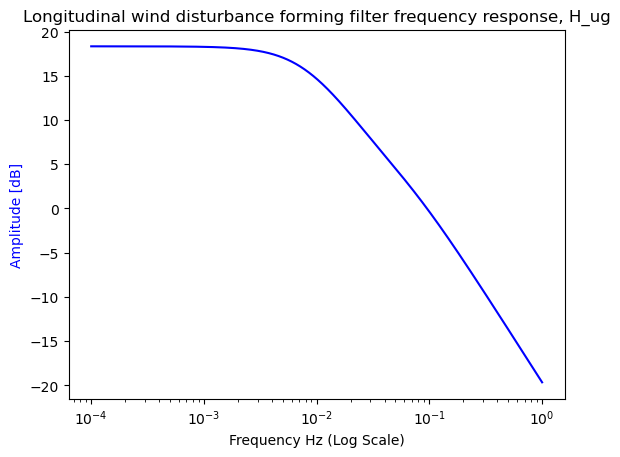

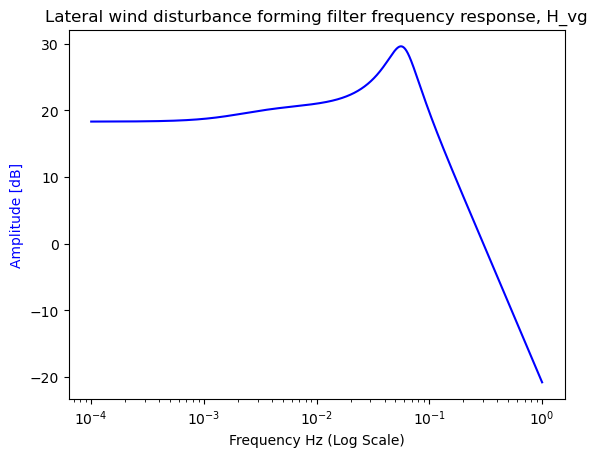

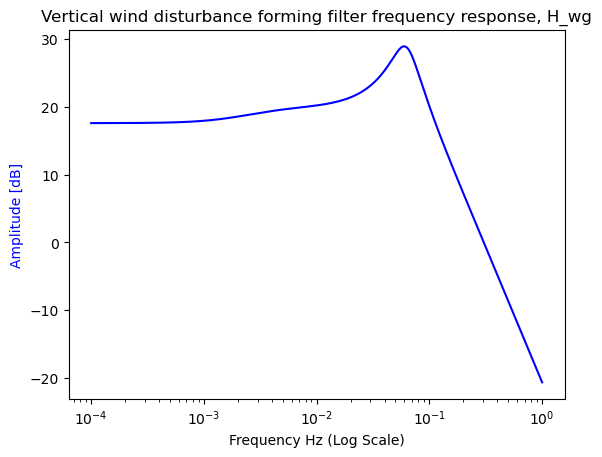

final_positon_error = 0.03701828712026518


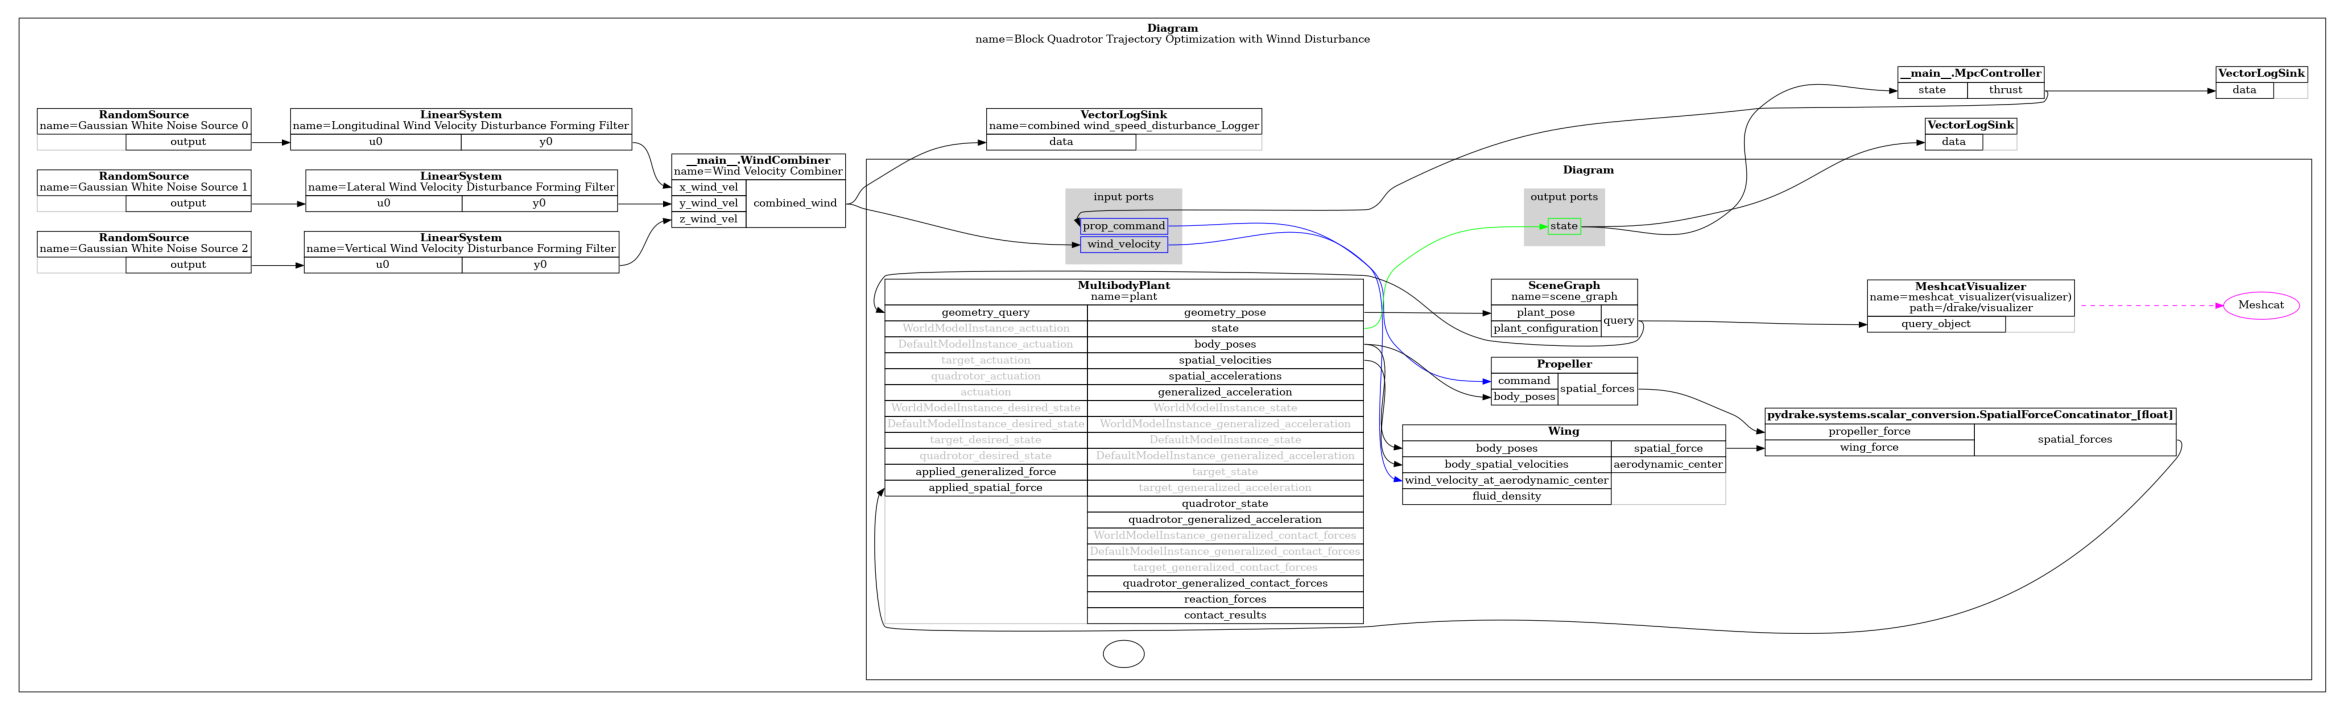

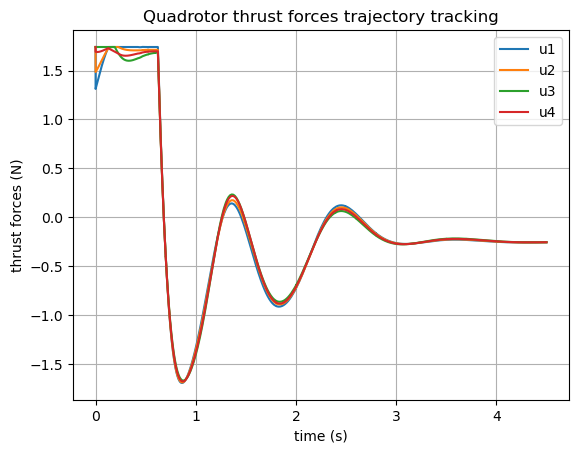

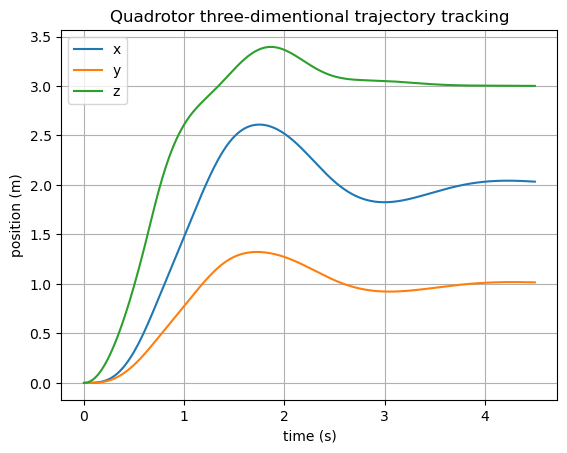

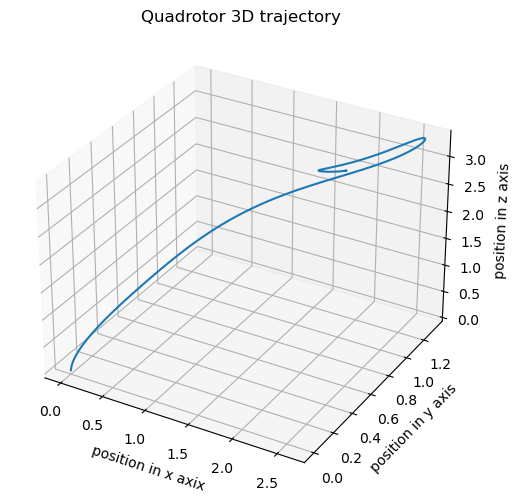

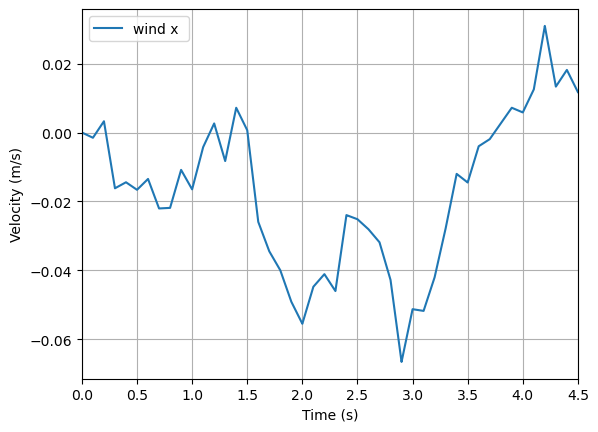

NameError: name 'winad_dat' is not defined

In [9]:
def run_linear_mpc():

    global fig_num

    #calculate optimal trajectory and simulation
    initial_state = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
    # target state for trajectory optimization
    final_state = [2.0, 1.0, 3.0, 0., 0., 0., 0., 0., 0., 0., 0., 0.]
    # limit of thrust force for each individual propellor

    # mass of quadrotor = 775g, typical thrust ratio is 2:1, so ~1600g thrust
    # 1600/4 = 400g thrust / propeller = 3.92 newtons
    # increased thrust ratio to 5.0 
    # 5 N = 509g; 509*4  = 2036, 
    # 2036 / 775 = 2.63 thrust / weight ratio
    thrust_limit = 2
    
    #we want to have an odd number
    num_time_samples = 6
    # number of samples into future we will run trajectory optimization
    time_horizon = 6

    #insantiate builder to connect high level system components
    world_builder = DiagramBuilder()

    # instatiate builder to build quadrotor by connecting MultiBodyPlant + Propellers
    quadrotor_builder = DiagramBuilder()

    # define world multibody plant containing quadrotor body and obstacles
    world_plant, scene_graph = AddMultibodyPlantSceneGraph(quadrotor_builder, time_step = 0.0)
    # world_plant, scene_graph = AddMultibodyPlantSceneGraph(world_builder, time_step = 0.0)


    # add obstacles to the simulated world
    obstacles = []
    #obs_height = 1.5
    #obs_width = 1.3
    #obs_depth = 1.3
    #obstacles.append(Obstacle("tree_obstacle1.sdf",[2.5, 1.5, 0.5],"tree_body", 
         #obs_height, obs_width, obs_depth))
    #obstacles.append(Obstacle("tree_obstacle2.sdf",[-2.5, 1.5, 0.5], "tree_body", 
         #obs_height, obs_width, obs_depth))
    #obstacles.append(Obstacle("tree_obstacle3.sdf",[0, 1.5, 0.5], "tree_body", 
         #obs_height, obs_width, obs_depth))

    #for obs in obstacles:
         #obs.connect_obstacle_to_world(world_plant, scene_graph)




    # #finalize the world plant
    # world_plant.Finalize()

    # visualize target
    target_position = final_state[:3]
    parser = Parser(world_plant, scene_graph)
    target_instance = parser.AddModelFromFile("target.sdf")
    target_body = world_plant.GetBodyByName("target_body")
    world_plant.WeldFrames(world_plant.world_frame(), target_body.body_frame(), RigidTransform(p=target_position))
    
    #parser = Parser(world_plant, scene_graph)
    #point_instance = parser.AddModelFromFile("trajectory_point.sdf")
    #point_body = world_plant.GetBodyByName("point_body")


    ####### Import .urdf files, connect quad body to propellers, connect geometry to scene graph
    quadrotor_plant, visualizer = create_quadrotor(quadrotor_builder, world_plant, scene_graph, obstacles)

    ####### Add quadrotor to top level diagram builder #####
    world_builder.AddSystem(quadrotor_plant)


    ##################### Create Dryden Wind Disturbance Model ################

    sampling_interval = 0.1 # seconds
    altitude = 900 #ft
    wind_speed = 10 # knots (worst case parameters) ~ 50 MPH
    vehicle_speed = 10 # m/s (specify worst case parameters) DJI Mavic II Pro has top speed of 20 m/s

    dryden = DrydenWindDisturbance(sampling_interval)
    wind_disturbance_src = dryden.create_wind_disturbance_model(altitude, wind_speed,vehicle_speed, world_builder)

    ################ Connect wind disturbance output to wind velocity input on wing of quadrotor 
    world_builder.Connect(wind_disturbance_src.get_output_port(0), quadrotor_plant.get_input_port(1))

    logger_wind = LogVectorOutput(wind_disturbance_src.get_output_port(), world_builder)
    logger_wind.set_name('combined wind_speed_disturbance_Logger')


    initial_thrust = [0., 0., 0., 0.]
    time_step = 0.1
    mpc_controller = MpcController(quadrotor_plant, initial_state, final_state, time_horizon, 
    num_time_samples, thrust_limit, obstacles, initial_thrust, time_step)
    mpc_controller = world_builder.AddSystem(mpc_controller)

    # connect the MPC controller to the quadrotor
    world_builder.Connect(mpc_controller.get_output_port(0), quadrotor_plant.get_input_port(0))
    world_builder.Connect(quadrotor_plant.get_output_port(0), mpc_controller.get_input_port(0))
    #world_builder.Connect(wind_disturbance_src.get_output_port(0), mpc_controller.get_input_port(1))

    #connect loggers to log state and input over the course of sim
    input_logger = LogVectorOutput(mpc_controller.get_output_port(0), world_builder)
    state_logger = LogVectorOutput(quadrotor_plant.get_output_port(0), world_builder)
    #point_position = state_logger
    

    


    ################# Run Simulation ####################
    #Set up a simulator to run this diagram
    diagram = world_builder.Build()

    simulator = Simulator(diagram)
    sim_context = simulator.get_mutable_context()
    # sim_context.SetContinuousState(initial_state)
    quadrotor_context = quadrotor_plant.GetMyMutableContextFromRoot(sim_context)
    quadrotor_context.SetContinuousState(initial_state)

    # print(f"Collsion detected? {obstacles[0].detect_collision(sim_context)}")

    # pass sim context into MpC controller to be used for linearization of dynamics
    mpc_controller.set_sim_context(sim_context)
    quadrotor_context = quadrotor_plant.GetMyMutableContextFromRoot(sim_context)
    mpc_context = mpc_controller.GetMyMutableContextFromRoot(sim_context)

    # quadrotor_plant.get_input_port(0).FixValue(quadrotor_context, [10.,10.,10.,10.])\
    
    #fix wind velocity input
    # quadrotor_plant.get_input_port(1).FixValue(quadrotor_context, [1e-9,1e-9,1e-9])
    # mpc_controller.get_input_port(1).FixValue(mpc_context, [1e-9,1e-9,1e-9])
    end_time = 10.0
    simulator.set_target_realtime_rate(10.0)


    

    # Simulate and animate
    meshcat.AddButton('Stop Simulation')
    # while simulator.get_context().get_time() < end_time:
    visualizer.StartRecording()
    sim_time = 0.0
    while meshcat.GetButtonClicks('Stop Simulation') < 1:

        #world_plant.WeldFrames(world_plant.world_frame(), point_body.body_frame(), RigidTransform(p=point_position))
        simulator.AdvanceTo(sim_context.get_time() + 0.1)
        sim_time += 0.1

    meshcat.DeleteAddedControls()
    
   

    
    measured_final_state = quadrotor_context.get_continuous_state().get_vector().CopyToVector()
    final_pos_error = measured_final_state[:3] - final_state[:3]
    final_error_2_norm = np.linalg.norm(final_pos_error)

    print(f"final_positon_error = {final_error_2_norm}")

    visualizer.StopRecording()
    visualizer.PublishRecording()

    ############### Visualize 
    # give names to the blocks (just to make the plot nicer)
    diagram.set_name('Block Quadrotor Trajectory Optimization with Winnd Disturbance')
    # plot current diagram
    plt.figure(fig_num, figsize=(30, 30))
    fig_num += 1
    plot_system_graphviz(diagram)




############### Plot the quadrotor thrust trajectory #########
    input_log = input_logger.FindLog(simulator.get_context())
    plt.figure(fig_num)
    # Plotting both the curves simultaneously
    plt.plot(input_log.sample_times(), input_log.data()[0]-2.4, label='u1')
    plt.plot(input_log.sample_times(), input_log.data()[1]-2.4, label='u2')
    plt.plot(input_log.sample_times(), input_log.data()[2]-2.4, label='u3')
    plt.plot(input_log.sample_times(), input_log.data()[3]-2.4, label='u4')

    # Naming the x-axis, y-axis and the whole graph
    plt.grid(True)
    plt.xlabel("time (s)")
    plt.ylabel("thrust forces (N)")
    plt.title("Quadrotor thrust forces trajectory tracking")
    plt.legend()
    plt.show()
    fig_num+=1

############### Plot the quadrotor position trajectory #########
    state_log = state_logger.FindLog(simulator.get_context())
    plt.figure(fig_num)
    # Plotting both the curves simultaneously
    plt.plot(state_log.sample_times(), state_log.data()[0], label='x')
    plt.plot(state_log.sample_times(), state_log.data()[1], label='y')
    plt.plot(state_log.sample_times(), state_log.data()[2], label='z')

    # Naming the x-axis, y-axis and the whole graph
    plt.grid(True) 
    plt.xlabel("time (s)")
    plt.ylabel("position (m)")
    plt.title("Quadrotor three-dimentional trajectory tracking")
    # Adding legend, which helps us recognize the curve according to it's color
    plt.legend()
    # To load the display window
    plt.show()



    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')  # Create a 3D axis
    ax.plot3D(state_log.data()[0], state_log.data()[1], state_log.data()[2])
    ax.set_xlabel('position in x axix')
    ax.set_ylabel('position in y axis')
    ax.set_zlabel('position in z axis')
    ax.set_title("Quadrotor 3D trajectory")



    ############### Plot Combined wind velocities ######################    
    plt.figure(fig_num)
    fig_num +=1
    # longitudinal wind velocity as a function of time
    wind_log = logger_wind.FindLog(sim_context)
    wind_data = wind_log.data()
    print()

    plt.plot(
        wind_log.sample_times(),
        wind_data[0],
        label='wind x '
    )

    # misc plot settings
    plt.ylabel('Velocity (m/s)')
    plt.xlabel('Time (s)')
    plt.xlim(0, sim_time)
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.plot(
        wind_log.sample_times(),
        winad_dat[1],
        label='wind y '
    )

    # misc plot settings
    plt.ylabel('Velocity (m/s)')
    plt.xlabel('Time (s)')
    plt.xlim(0, sim_time)
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.plot(
        wind_log.sample_times(),
        wind_data[2],
        label='wind z '
    )

    # misc plot settings
    plt.ylabel('Velocity (m/s)')
    plt.xlabel('Time (s)')
    plt.xlim(0, sim_time)
    plt.grid(True)
    plt.legend()
    plt.show()


# Simulate MPC of quadrotor
run_linear_mpc()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=385c23f0-60d3-43e9-8424-58e951645a69' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>